# 4 Modeling<a id='4_Modeling'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Modeling](#4_modeling)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports and Load Data](#4.3_Imports)
      * [4. Functions](#4._Functions)   
  * [4.4 Random Forests Classifier](#4.4_Random_Forests)
      * [4.4.1 Define X and y](#4._X_y)
      * [4.4.2 Confusion Matrix](#4.4.2_confusion_matrix)
      * [4.4.2 Hyperparameter Tuning - Randomized Search](#4.4.2_randomized_search)  
      * [4.4.3 Hyperparameter Tuning - Grid Search](#4.4.3_grid_search)
  * [4.5 K-Means Clustering](#4.5_kmeans_clustering)
      * [4.5.1 Visualizing Clusters with PCA](#4.5.1_PCA)


## 4.2 Introduction<a id='4.2_Introduction'></a>

This notebook uses a Random Forests classifier to attempt to predict nonvoters from some of the survey responses. After that, a smaller subset of the data is used with K-Means clustering to attempt to cluster the voters into different types.

## 4.3 Imports and Load Data<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [2]:
# import Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [3]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,log_loss
from matplotlib import pyplot


In [4]:
import itertools
from sklearn import svm, datasets

In [5]:
from sklearn.tree import export_graphviz
from subprocess import run
from IPython.display import Image

In [6]:
from sklearn.model_selection import RandomizedSearchCV

In [7]:
from sklearn.cluster import KMeans
import numpy as np

In [8]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

In [9]:
from sklearn.decomposition import PCA

In [10]:
df = pd.read_csv('nonvoters_dummies.csv').drop(['Unnamed: 0'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Columns: 221 entries, Q32_1.0 to Q9_2_4
dtypes: int64(221)
memory usage: 9.8 MB


In [112]:
df.head()

Q7_1  Q7_2  Q5_1  Q5_2  Q4_3_1  Q4_3_2  Q4_3_3  Q4_3_4  Q23_1  Q23_2  ...  \
0     1     0     1     0       0       1       0       0      0      1  ...   
1     0     1     1     0       0       1       0       0      1      0  ...   
2     1     0     1     0       0       0       1       0      0      1  ...   
3     1     0     1     0       0       1       0       0      0      1  ...   
4     0     1     1     0       1       0       0       0      1      0  ...   

   Q9_4_3  Q9_4_4  Q2_7_1  Q2_7_2  Q2_7_3  Q2_7_4  income_cat_$40-75k  \
0       0       1       0       1       0       0                   0   
1       0       1       0       1       0       0                   0   
2       0       1       0       1       0       0                   0   
3       0       1       1       0       0       0                   1   
4       0       1       1       0       0       0                   1   

   income_cat_$75-125k  income_cat_Less than $40k  Voter ID  
0                    1                          0    470001  
1                    0                          0    470002  
2                    0                          0    470003  
3                    0                          0    470007  
4                    0                          0    480008  

[5 rows x 222 columns]

In [11]:
col_sorted = sorted(df.columns)

In [12]:
df = df[col_sorted]

In [13]:
df.shape

(5836, 222)

## 4. Functions <a id='4._Functions'></a> 

In [14]:
def feature_importance(clf, X):
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
    sorted_idx = np.argsort(feature_importance)[:30]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    return plt.show()

In [15]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(['voter_category_sporadic','voter_category_rarely/never'], axis=1)
    y = df['voter_category_rarely/never']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X, y, X_train, X_test, y_train, y_test) 

In [16]:
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
def print_tree(clf, X):
    estimator = clf.estimators_[5]
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = X.columns,
                    class_names = ['0','1'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)
    # Convert to png using system command (requires Graphviz)
    run(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
    # Display in jupyter notebook
    return Image(filename = 'tree.png')

In [18]:
def RF_model_results(clf, X_train, X_test, y_train, y_test):
    model_res = clf.fit(X_train, y_train)
    y_pred = model_res.predict(X_test)
    y_pred_prob = model_res.predict_proba(X_test)
    lr_probs = y_pred_prob[:,1]
    
    ac = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print('Random Forest: Test Accuracy=%.3f' % (ac))
    print('Random Forest: Test Precision=%.3f' % (prec))
    print('Random Forest: Test Recall=%.3f' % (rec))
    print(cm)
    y_pred_train = model_res.predict(X_train)
    train_ac = accuracy_score(y_train, y_pred_train)
    train_rec = recall_score(y_train, y_pred_train)
    train_prec = precision_score(y_train, y_pred_train)
    print('Random Forest: Train Accuracy=%.3f' % (train_ac))
    print('Random Forest: Train Precision=%.3f' % (train_prec))
    print('Random Forest: Train Recall=%.3f' % (train_rec))
    return (model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec)

## 4.4 Random Forests Classifier<a id='4.4_Random_Forests'></a> 

### 4.4.1 Prediction with Q 26, 27<a id='4.4.1_Q26_27'></a> 

Check if questions 26 and 27 alone can accurately predict labels. They should since they ask explicitly how often they vote and which elections they voted in.

In [19]:
df_wrangled = pd.read_csv('nonvoters_wrangled.csv').drop('Unnamed: 0',axis=1)
df_26_27 = df_wrangled[['Q26','Q27_1','Q27_2','Q27_3','Q27_4',
                       'Q27_5','Q27_6','voter_category']].astype(object)

In [49]:
df_26_27_dum = pd.get_dummies(df_26_27, drop_first=True)

In [50]:
X_27, y_27, X_train_27, X_test_27, y_train_27, y_test_27 = split_data(df_26_27_dum)

In [53]:
clf_27 = RandomForestClassifier(bootstrap=True, class_weight='balanced', 
    max_depth=None,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=500, random_state = 123, n_jobs=-1)

model_res_27, y_pred_27, y_pred_prob_27, lr_probs_27, ac_27, prec_27, rec_27, cm_27, train_ac_27, train_rec_27, train_prec_27 = RF_model_results(clf_27, X_train_27, X_test_27, y_train_27, y_test_27)

Random Forest: Test Accuracy=0.846
Random Forest: Test Precision=0.683
Random Forest: Test Recall=0.692
[[790  92]
 [ 88 198]]
Random Forest: Train Accuracy=0.870
Random Forest: Train Precision=0.733
Random Forest: Train Recall=0.751


In [54]:
test_results = pd.concat([X_test_27,y_test_27], axis=1) 
test_results['prediction'] = y_pred_27
misclassified = test_results[test_results['voter_category_rarely/never']!=test_results['prediction']]
correct = test_results[test_results['voter_category_rarely/never']==test_results['prediction']]


In [55]:
misclassified.groupby('prediction').mean()

Q26_1     Q26_2     Q26_3     Q26_4   Q27_1_1   Q27_1_2  \
prediction                                                               
0           0.920455  0.079545  0.000000  0.000000  0.772727  0.215909   
1           0.489130  0.326087  0.086957  0.054348  0.402174  0.543478   

             Q27_2_1   Q27_2_2   Q27_3_1   Q27_3_2   Q27_4_1  Q27_4_2  \
prediction                                                              
0           0.931818  0.068182  0.625000  0.352273  0.852273  0.12500   
1           0.673913  0.271739  0.391304  0.554348  0.434783  0.51087   

             Q27_5_1   Q27_5_2   Q27_6_1   Q27_6_2  \
prediction                                           
0           0.511364  0.454545  0.647727  0.318182   
1           0.228261  0.717391  0.326087  0.619565   

            voter_category_rarely/never  
prediction                               
0                                   1.0  
1                                   0.0

In [57]:
correct.groupby('prediction').mean()

Q26_1     Q26_2     Q26_3     Q26_4   Q27_1_1   Q27_1_2  \
prediction                                                              
0           0.95443  0.041772  0.001266  0.001266  0.915190  0.082278   
1           0.10101  0.126263  0.297980  0.474747  0.121212  0.858586   

             Q27_2_1   Q27_2_2   Q27_3_1   Q27_3_2   Q27_4_1   Q27_4_2  \
prediction                                                               
0           0.987342  0.012658  0.843038  0.149367  0.963291  0.034177   
1           0.176768  0.797980  0.065657  0.914141  0.090909  0.888889   

             Q27_5_1   Q27_5_2   Q27_6_1   Q27_6_2  \
prediction                                           
0           0.807595  0.183544  0.921519  0.077215   
1           0.020202  0.959596  0.085859  0.893939   

            voter_category_rarely/never  
prediction                               
0                                   0.0  
1                                   1.0

Questions 26 and 27 do a decent job predicting voter category but the accuracy should be 100% (unless fivethirtyeight used some other basis for determining voter category that is not in the data).

Reassign voter_category for rows that are categorized incorrectly based on voter-reported voting history found in question 27.

First count and collect how many misassigned voters there are. Assign each voter a score based on how many times they have voted in recent elections.

In [110]:
df.head()

Q10_1_1  Q10_1_2  Q11_1_1  Q11_1_2  Q11_5_1  Q11_5_2  Q14_1  Q14_2  Q14_3  \
0        0        1        0        1        0        1      0      0      0   
1        0        1        0        1        0        1      1      0      0   
2        0        1        0        1        1        0      0      0      0   
3        0        1        1        0        1        0      0      0      0   
4        0        1        0        1        0        1      1      0      0   

   Q14_4  ...  educ_Some college  gender_Male  income_cat_$40-75k  \
0      0  ...                  0            0                   0   
1      0  ...                  0            0                   0   
2      0  ...                  0            1                   0   
3      0  ...                  1            0                   1   
4      0  ...                  0            1                   1   

   income_cat_$75-125k  income_cat_Less than $40k  race_Hispanic  \
0                    1                          0              0   
1                    0                          0              0   
2                    0                          0              0   
3                    0                          0              0   
4                    0                          0              0   

   race_Other/Mixed  race_White  voter_category_rarely/never  \
0                 0           1                            0   
1                 0           1                            0   
2                 0           1                            0   
3                 0           0                            0   
4                 0           1                            0   

   voter_category_sporadic  
0                        0  
1                        0  
2                        1  
3                        1  
4                        0  

[5 rows x 221 columns]

In [21]:
df_corrected = df_wrangled.copy()
misassigned = pd.DataFrame(columns=['Cat','index','misclassified_as','score','age'])
len(misassigned)

0

In [23]:
# assign scores
df_corrected['score']=0
for i in range(len(df_corrected)):
    score = 0
    for col in ['Q27_1', 'Q27_2', 'Q27_3', 'Q27_4', 'Q27_5', 'Q27_6']:
        if df_corrected.loc[i,col]==1:
            score += 1
    df_corrected.loc[i,'score']=score

In [25]:
#reassigned rows voter category

count1, count2, count3, count4 = (0,0,0,0)
for i in range(len(df_corrected)):    
    if (df_corrected.loc[i,'score']==0) & (df_corrected.loc[i,'voter_category']!='rarely/never'):
        
        misassigned.loc[len(misassigned.index)] = [1, i, df_corrected.loc[i,'voter_category'], df_corrected.loc[i,'score'], df_corrected.loc[i,'ppage']] 
        df_corrected.loc[i,'voter_category']='rarely/never'
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_rarely/never']]=1
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_sporadic']]=0
        count1 += 1
    elif (df_corrected.loc[i,'score']==1) & (df_corrected.loc[i,'ppage']>22) & (df_corrected.loc[i,'voter_category']!='rarely/never'):
        misassigned.loc[len(misassigned.index)] = [2, i, df_corrected.loc[i,'voter_category'], df_corrected.loc[i,'score'], df_corrected.loc[i,'ppage']] 
        df_corrected.loc[i,'voter_category']='rarely/never'
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_rarely/never']]=1
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_sporadic']]=0
        count2 += 1
    elif ((df_corrected.loc[i,'score']>=3)&(df_corrected.loc[i,'score']<=5)) & (df_corrected.loc[i,'voter_category']=='rarely/never'):
        misassigned.loc[len(misassigned.index)] = [3, i, df_corrected.loc[i,'voter_category'], df_corrected.loc[i,'score'], df_corrected.loc[i,'ppage']] 
        df_corrected.loc[i,'voter_category']='sporadic'
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_rarely/never']]=0
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_sporadic']]=1
        count3 += 1
    elif (df_corrected.loc[i,'score']==6) & (df_corrected.loc[i,'voter_category']!='always'):
        misassigned.loc[len(misassigned.index)] = [4, i, df_corrected.loc[i,'voter_category'], df_corrected.loc[i,'score'], df_corrected.loc[i,'ppage']] 
        df_corrected.loc[i,'voter_category']='always'
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_rarely/never']]=0
        df.loc[df['Voter ID']==df_corrected.loc[i,'RespId'],['voter_category_sporadic']]=0
        count4 += 1
print(count1,count2,count3,count4)

79 88 265 1742


In [26]:
misassigned[misassigned['Cat']!=4].sample(10)

Cat index misclassified_as score age
2151   3  5778     rarely/never     3  53
1819   3  4958     rarely/never     5  53
1985   3  5381     rarely/never     4  30
1983   3  5377     rarely/never     5  75
1452   2  3892           always     1  25
1879   3  5096     rarely/never     3  74
1610   2  4329           always     1  23
275    2   756         sporadic     1  61
1364   3  3633     rarely/never     5  38
1708   3  4614     rarely/never     4  50

In [27]:
# show any voters still misassigned
df_corrected[(df_corrected['score']<=1) & (df_corrected['voter_category']=='always')]

RespId  weight  Q2_1  Q2_2  Q2_3  Q2_4  Q2_5  Q2_6  Q2_7  Q2_8  ...  \
1873  472499  1.2770     2     3     2     3     2     2     2     2  ...   
2587  473451  1.1177     1     1     1     4     1     4     4     2  ...   
3146  474194  1.4129     1     1     1     4     2     1     2     1  ...   
4318  475659  1.0201     1     1     1     4     3     3     4     1  ...   
4334  475680  1.7053     1     2     3     3     2     1     2     2  ...   
4361  475719  1.1287     1     1     1     3     1     2     2     1  ...   
4367  475728  0.8419     1     1     1     1     2     1     1     2  ...   
4375  486179  0.9637     1     1     2     4     1     4     4     2  ...   
4416  475810  1.1193     2     3     2     4     1     3     3     3  ...   
4429  475837  0.8427     1     4     1     2     1     4     3     3  ...   
4804  476321  0.9224     1     3     3     2     1     2     1     2  ...   
5574  487957  1.0928     2     1     2     2     1     2     1     1  ...   

      Q31  Q32  Q33  ppage                 educ         race  gender  \
1873  NaN  1.0  NaN     22              College        White  Female   
2587  NaN  1.0  NaN     22         Some college        White  Female   
3146  NaN  NaN  1.0     22  High school or less        White  Female   
4318  NaN  NaN  2.0     22         Some college     Hispanic    Male   
4334  NaN  NaN  2.0     22         Some college     Hispanic    Male   
4361  NaN  NaN  2.0     22         Some college  Other/Mixed  Female   
4367  2.0  NaN  NaN     22         Some college        White    Male   
4375  NaN  1.0  NaN     22         Some college        White    Male   
4416  NaN  1.0  NaN     22         Some college     Hispanic  Female   
4429  1.0  NaN  NaN     22         Some college        White    Male   
4804  1.0  NaN  NaN     22         Some college        White    Male   
5574  NaN  NaN  1.0     22         Some college        White  Female   

          income_cat  voter_category  score  
1873   $125k or more          always      1  
2587        $75-125k          always      1  
3146         $40-75k          always      1  
4318        $75-125k          always      1  
4334   $125k or more          always      1  
4361  Less than $40k          always      1  
4367  Less than $40k          always      1  
4375         $40-75k          always      1  
4416  Less than $40k          always      1  
4429         $40-75k          always      1  
4804        $75-125k          always      1  
5574  Less than $40k          always      1  

[12 rows x 94 columns]

12 voters aged 22 with a score of 1 assigned to 'Always.' It's a small number so I'll let it be.

In [28]:
# show any voters still misassigned
df_corrected[(df_corrected['score']>=5) & (df_corrected['voter_category']=='rarely/never')]

Empty DataFrame
Columns: [RespId, weight, Q2_1, Q2_2, Q2_3, Q2_4, Q2_5, Q2_6, Q2_7, Q2_8, Q2_10, Q3_1, Q3_2, Q3_3, Q3_4, Q3_5, Q4_1, Q4_2, Q4_3, Q4_4, Q4_5, Q4_6, Q5, Q6, Q7, Q8_1, Q8_2, Q8_3, Q8_4, Q8_5, Q8_6, Q8_7, Q8_8, Q8_9, Q9_1, Q9_2, Q9_3, Q9_4, Q10_1, Q11_1, Q11_5, Q14, Q15, Q16, Q17_1, Q17_2, Q17_3, Q18_3, Q18_7, Q18_9, Q19_1, Q19_2, Q19_6, Q19_8, Q19_9, Q20, Q21, Q22, Q23, Q24, Q25, Q26, Q27_1, Q27_2, Q27_3, Q27_4, Q27_5, Q27_6, Q28_1, Q28_2, Q28_3, Q28_4, Q28_5, Q28_6, Q28_7, Q28_8, Q29_3, Q29_4, Q29_5, Q29_6, Q29_8, Q29_9, Q29_10, Q30, Q31, Q32, Q33, ppage, educ, race, gender, income_cat, voter_category, score]
Index: []

[0 rows x 94 columns]

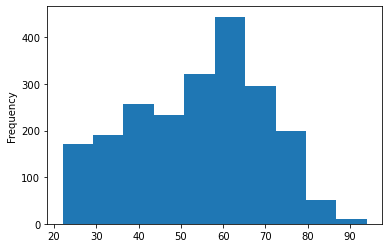

In [29]:
misassigned.age.plot(kind='hist')
plt.show()

In [31]:
checkDF = pd.concat([df_corrected[['ppage','RespId','voter_category','score']],df[['Voter ID','voter_category_rarely/never','voter_category_sporadic']]],axis=1)

In [32]:
checkDF.sample(10)

ppage  RespId voter_category  score  Voter ID  \
381      81  470518         always      6    470518   
1467     52  471954   rarely/never      0    471954   
2067     30  472747   rarely/never      0    472747   
1389     31  471848       sporadic      3    471848   
161      78  470216         always      6    470216   
5015     38  487160         always      6    487160   
1274     42  471698       sporadic      3    471698   
3335     63  474450         always      5    474450   
1384     61  471838         always      6    471838   
642      85  470870         always      6    470870   

      voter_category_rarely/never  voter_category_sporadic  
381                             0                        0  
1467                            1                        0  
2067                            1                        0  
1389                            0                        1  
161                             0                        0  
5015                            0                        0  
1274                            0                        1  
3335                            0                        0  
1384                            0                        0  
642                             0                        0

In [33]:
df_26_27['voter_category'].value_counts()

sporadic        2574
always          1811
rarely/never    1451
Name: voter_category, dtype: int64

In [34]:
checkDF['voter_category'].value_counts()

always          3497
rarely/never    1171
sporadic        1168
Name: voter_category, dtype: int64

In [35]:
df_corr_dum = pd.get_dummies(df.drop('Voter ID',axis=1), drop_first=True)


In [36]:
df_corr_dum.shape

(5836, 221)

## 4. Define X and y<a id='4._X_y'></a> 

X and y are generated below. df_corr_dum is data that removes unnecessary or unhelpful features (including Voter Id, weight, and several questions from survey) and recategorizes some of the voters based on their answers to question 27 which asks which elections they voted in.

In [37]:
# run Random Forest classifier with corrected data
X, y, X_train, X_test, y_train, y_test = split_data(df_corr_dum)

In [38]:
clf = RandomForestClassifier(bootstrap=False, 
    class_weight='balanced_subsample', 
    max_depth=5,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=10, 
    n_estimators=300, random_state = 123, n_jobs=-1)
# 'n_estimators': 290, 'min_samples_split': 50, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'class_weight': None, 'bootstrap': True
#'n_estimators': 230, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample', 'bootstrap': False
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(clf, X_train, X_test, y_train, y_test)

Random Forest: Test Accuracy=0.824
Random Forest: Test Precision=0.537
Random Forest: Test Recall=0.677
[[810 132]
 [ 73 153]]
Random Forest: Train Accuracy=0.844
Random Forest: Train Precision=0.590
Random Forest: Train Recall=0.749


In [39]:
pred_prob_1 = []
for i in range(len(y_pred_prob)):
    pred_prob_1.append(y_pred_prob[i][1])
pred_prob_1 = np.array(pred_prob_1)

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob_1, pos_label=1)

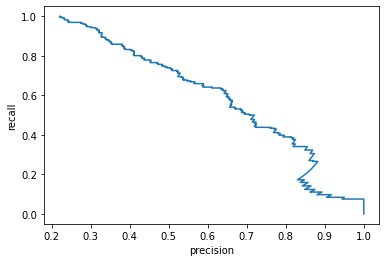

In [41]:
_ = plt.plot(precision, recall)
_ = plt.xlabel('precision')
_ = plt.ylabel('recall')
plt.show()

In [42]:
PR = sorted(list(zip(precision,recall)))
precision,recall = zip(*PR)

In [43]:
auc(precision, recall)

0.44555856696568574

30


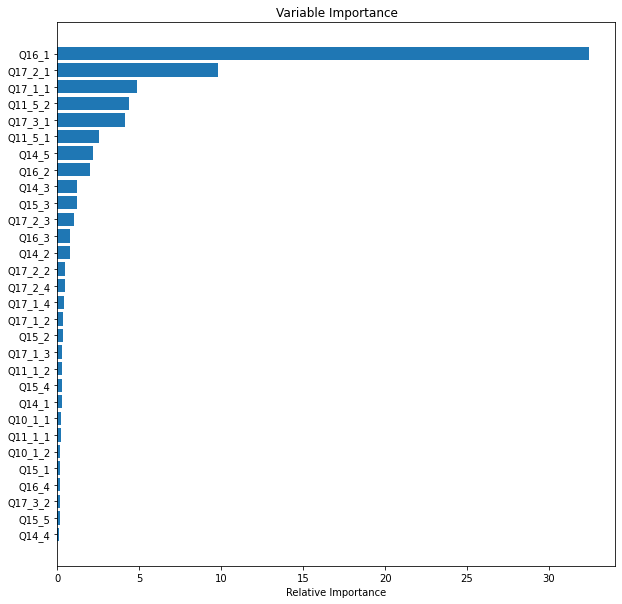

In [44]:
feature_importance(clf, X)

## 4.4.2 Confusion Matrix<a id='4.4.2_confusion_matrix'></a> 

Confusion matrix, without normalization
[[810 132]
 [ 73 153]]
Normalized confusion matrix
[[0.86 0.14]
 [0.32 0.68]]


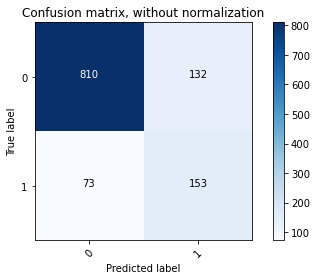

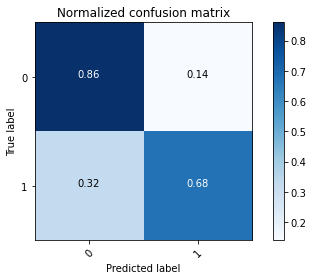

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

In [59]:
print_tree(clf, X)

## 4.4.2 Hyperparameter Tuning - Randomized Search<a id='4.4.2_randomized_search'></a> 

In [147]:
X_train.shape

(4668, 219)

In [149]:
np.linspace(3, 43, num = 11)

array([ 3.,  7., 11., 15., 19., 23., 27., 31., 35., 39., 43.])

In [146]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(20, 320, 11)]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 43, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of class balance
class_weight=['balanced','balanced_subsample',None]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [155]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 200, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)
rf_random.best_params_

{'n_estimators': 230,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'class_weight': 'balanced_subsample',
 'bootstrap': False}

{'n_estimators': 290,
 'min_samples_split': 50,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 3,
 'class_weight': None,
 'bootstrap': True}

In [55]:
RS_scores = pd.DataFrame(rf_random.cv_results_)

In [56]:
RS_scores.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.530109      0.049578         0.275030        0.002656   
1       1.475662      0.025107         0.084820        0.005886   
2       0.422836      0.006481         0.041920        0.005413   
3       5.016238      0.029126         0.261768        0.009899   
4       6.239395      0.049293         0.271818        0.004566   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                320                       2                      2   
1                 80                       2                      4   
2                 20                       5                      2   
3                290                       5                      2   
4                320                       2                      2   

  param_max_features param_max_depth param_class_weight  ...  \
0               log2              10           balanced  ...   
1               sqrt              50           balanced  ...   
2               sqrt              40               None  ...   
3               log2              80               None  ...   
4               sqrt              30               None  ...   

  std_test_precision rank_test_precision  split0_test_recall  \
0           0.033094                  39            0.647482   
1           0.038637                  41            0.582734   
2           0.040759                  18            0.388489   
3           0.044945                  11            0.381295   
4           0.041819                  13            0.431655   

   split1_test_recall  split2_test_recall  split3_test_recall  \
0            0.669065            0.625899            0.654676   
1            0.640288            0.582734            0.647482   
2            0.532374            0.388489            0.446043   
3            0.496403            0.345324            0.395683   
4            0.561151            0.381295            0.446043   

   split4_test_recall  mean_test_recall  std_test_recall  rank_test_recall  
0            0.762590          0.671942         0.047417                 5  
1            0.748201          0.640288         0.060534                17  
2            0.503597          0.451799         0.058694                37  
3            0.467626          0.417266         0.056097                40  
4            0.561151          0.476259         0.072573                32  

[5 rows x 28 columns]

RECALL
{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10,
 'class_weight': 'balanced',
 'bootstrap': True}
ROC - AUC
{'n_estimators': 320,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'class_weight': 'balanced_subsample',
 'bootstrap': False}
PRECISION
 'n_estimators': 170,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'class_weight': 'balanced_subsample',
 'bootstrap': True

In [48]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

## 4.4.3 Hyperparameter Tuning - Grid Search<a id='4.4.3_grid_search'></a> 

In [142]:
from sklearn.model_selection import GridSearchCV


In [143]:
# Minimum number of samples required to split a node
min_samples_split = [2,5,7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 7]
# Maximum number of levels in tree
max_depth = [50,80,None]
# Class weight
class_weight = ['balanced_subsample',None]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the grid
param_grid = { 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

In [ ]:
# add parameters to grid
rf = RandomForestClassifier(n_estimators=100)
rf_cv= GridSearchCV(rf,param_grid,cv=5)
rf_cv.fit(X_train,y_train)
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Parameters:
    bootstrap=False, 
    max_depth=90,
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200
    

In [55]:
#clf = RandomForestClassifier(  random_state = None, n_jobs=-1)
clf = RandomForestClassifier(bootstrap=False, class_weight='balanced', 
    max_depth=15,
    max_features=30, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, random_state = 42, n_jobs=-1)

model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(cm)

Random Forest: Accuracy=0.804
Random Forest: f1-score=0.786
[[823  59]
 [170 116]]


In [56]:
y_pred_train = model_res.predict(X_train)
ac = accuracy_score(y_train, y_pred_train)
ac

Unsupervised Learning: K-Means clustering

## 4.5 K-Means Clustering<a id='4.5_kmeans_clustering'></a> 

In [60]:
X.columns

Index(['Q10_1_1', 'Q10_1_2', 'Q11_1_1', 'Q11_1_2', 'Q11_5_1', 'Q11_5_2',
       'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4',
       ...
       'age_66+', 'educ_High school or less', 'educ_Some college',
       'gender_Male', 'income_cat_$40-75k', 'income_cat_$75-125k',
       'income_cat_Less than $40k', 'race_Hispanic', 'race_Other/Mixed',
       'race_White'],
      dtype='object', length=219)

In [61]:
X.shape

(5836, 219)

In [62]:
X_top8 = X[['Q2_1_1','Q2_2_1','Q2_1_2','Q2_3_1','Q2_5_1','Q2_2_3','Q2_1_1','Q2_7_1']]
X_top5 = X[['Q2_1_1','Q2_2_1','Q2_1_2','Q2_3_1','Q2_5_1']]
X_best = X[['Q2_1_2', 'Q2_1_3', 'Q2_1_4', 'Q2_2_4', 'Q2_3_3', 'Q2_3_4', 'Q2_5_3', 'Q9_1_3', 'Q30_5']]
X_best2 = X[['Q2_1_3', 'Q2_1_4', 'Q2_3_4', 'Q2_5_3', 'Q9_1_3', 'Q30_5']]
# 'Q2_1_2': ('rarely/never', 2, 0.551490514905149, 407),
#  'Q2_1_3': ('rarely/never', 3, 0.7931034482758621, 115),
#  'Q2_1_4': ('rarely/never', 4, 0.83125, 133),
#  'Q2_2_4': ('rarely/never', 4, 0.5379061371841155, 149),
#  'Q2_3_3': ('rarely/never', 3, 0.5011135857461024, 225),
#  'Q2_3_4': ('rarely/never', 4, 0.675, 108),
#  'Q2_5_3': ('rarely/never', 3, 0.5459459459459459, 101),
#  'Q9_1_3': ('rarely/never', 3, 0.50625, 162),
#  'Q15_-1': ('rarely/never', -1, 0.53125, 102),
#  'Q30_5': ('rarely/never', 5, 0.5447761194029851, 365),
#  'Q33_-1.0': ('rarely/never', -1.0, 0.5197132616487455, 145),
#  'age_18-25'

In [63]:
x_cols = X.to_numpy()
x_cols

array([[0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [64]:
ss_means = []
k_list = []
for k in range(3,10): 
    ss = []
    k_list.append(k)
    for run in range(3):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit_predict(x_cols)
        ss.append(kmeans.inertia_)
    ss_means.append(np.mean(ss))
print(k_list,ss_means)

[3, 4, 5, 6, 7, 8, 9] [181747.88786151857, 179016.07684474686, 176635.38141392233, 174986.58856059634, 173511.04137285534, 172336.207243744, 171284.70382151334]


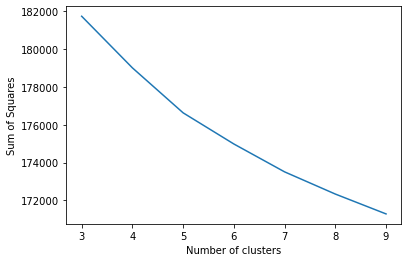

In [65]:
_ = plt.plot(k_list,ss_means)
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('Sum of Squares')
plt.show()

In [66]:
kmeans = KMeans(n_clusters=5)
kmeans.fit_predict(x_cols)

array([2, 3, 2, ..., 2, 0, 2])

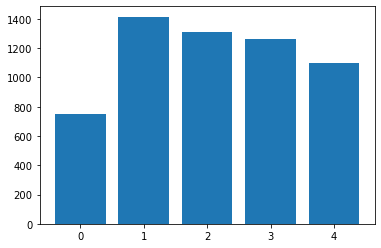

In [67]:
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)
_ = plt.bar(unique, counts)
plt.show()

In [68]:
silhouette_score(x_cols, labels)

0.037121070686812196

## 4.5.1 Visualizing Clusters with PCA<a id='4.5.1_PCA'></a> 
Visualizing clusters with PCA

In [69]:
voter_code = {'rarely/never':2,'sporadic':1,'always':0}
for i in range(len(df_wrangled)):
    df_wrangled.loc[i,'voter code'] = voter_code[df_wrangled.loc[i,'voter_category']]
df_wrangled.head()

RespId  weight  Q2_1  Q2_2  Q2_3  Q2_4  Q2_5  Q2_6  Q2_7  Q2_8  ...  Q31  \
0  470001  0.7516     1     1     2     4     1     4     2     2  ...  NaN   
1  470002  1.0267     1     2     2     3     1     1     2     1  ...  NaN   
2  470003  1.0844     1     1     2     2     1     1     2     1  ...  NaN   
3  470007  0.6817     1     1     1     3     1     1     1     1  ...  NaN   
4  480008  0.9910     1     1    -1     1     1     1     1     1  ... -1.0   

   Q32  Q33  ppage                 educ   race  gender     income_cat  \
0  1.0  NaN     73              College  White  Female       $75-125k   
1  NaN  1.0     90              College  White  Female  $125k or more   
2  2.0  NaN     53              College  White    Male  $125k or more   
3  1.0  NaN     58         Some college  Black  Female        $40-75k   
4  NaN  NaN     81  High school or less  White    Male        $40-75k   

   voter_category  voter code  
0          always         0.0  
1          always         0.0  
2        sporadic         1.0  
3        sporadic         1.0  
4          always         0.0  

[5 rows x 94 columns]

In [70]:
# choose number of components for PCA
n_components = 2
# choose number of cluster for K-Means clustering
n_clusters = 5
# choose dataframe subslice to convert to numpy array
x_cols = X.to_numpy()

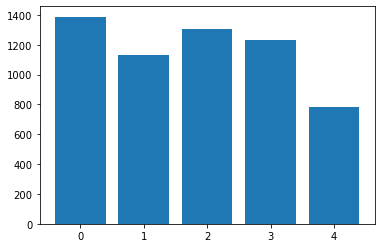

In [71]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit_predict(x_cols)
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)

pca = PCA(n_components=n_components)
pca.fit(df_corr_dum)
pca_data = pca.transform(df_corr_dum)
pca_df = pd.DataFrame({'x':pca_data[:,0],'y':pca_data[:,1]
                       ,'kmeans label':labels,'voter category':df_wrangled['voter_category']
                      ,'voter code':df_wrangled['voter code']})

_ = plt.bar(unique, counts)
plt.show()

In [72]:
# add labels from clustering to working DataFrame.
# make a summary DataFrame that groups and aggregates data by label.

df_labels = df_corr_dum.copy()
df_labels['labels']=labels
df_summary = df_labels.groupby('labels').mean()


In [73]:
df_summary

Q10_1_1   Q10_1_2   Q11_1_1   Q11_1_2   Q11_5_1   Q11_5_2     Q14_1  \
labels                                                                         
0       0.074207  0.923631  0.094380  0.903458  0.146254  0.853026  0.798271   
1       0.061947  0.937168  0.174336  0.822124  0.293805  0.705310  0.036283   
2       0.081288  0.918712  0.092025  0.907209  0.160276  0.838190  0.088190   
3       0.079675  0.917073  0.125203  0.872358  0.203252  0.795122  0.383740   
4       0.117347  0.866071  0.210459  0.776786  0.380102  0.607143  0.131378   

           Q14_2     Q14_3     Q14_4  ...  educ_Some college  gender_Male  \
labels                                ...                                   
0       0.160663  0.014409  0.002882  ...           0.311239     0.549712   
1       0.081416  0.105310  0.114159  ...           0.277876     0.538053   
2       0.151840  0.124233  0.092025  ...           0.277607     0.486963   
3       0.320325  0.173171  0.047154  ...           0.309756     0.435772   
4       0.214286  0.311224  0.068878  ...           0.281888     0.507653   

        income_cat_$40-75k  income_cat_$75-125k  income_cat_Less than $40k  \
labels                                                                       
0                 0.262248             0.293948                   0.183718   
1                 0.231858             0.301770                   0.192035   
2                 0.220859             0.282975                   0.223160   
3                 0.231707             0.298374                   0.246341   
4                 0.251276             0.182398                   0.448980   

        race_Hispanic  race_Other/Mixed  race_White  \
labels                                                
0            0.096542          0.039625    0.840058   
1            0.149558          0.100885    0.463717   
2            0.151840          0.051380    0.560583   
3            0.134959          0.069919    0.717073   
4            0.186224          0.075255    0.519133   

        voter_category_rarely/never  voter_category_sporadic  
labels                                                        
0                          0.102305                 0.142651  
1                          0.141593                 0.272566  
2                          0.055982                 0.139571  
3                          0.246341                 0.273984  
4                          0.628827                 0.182398  

[5 rows x 221 columns]

In [74]:
# make a dictionary where the keys are the labels and the values
# are a list of tuples with the five most important features listed
# second.

n = 5
top_feat_dict = {}
for row in df_summary.index:
    top5 = [(0,0),(0,0),(0,0),(0,0),(0,0)]
    for col in df_summary.columns:
        if df_summary.loc[row,col] > top5[4][0]:
            top5[4] = (df_summary.loc[row,col],col)
            top5.sort(reverse=True)
    top_feat_dict[row]=top5

In [75]:
top_feat_dict

{0: [(0.9726224783861671, 'Q18_3_2'),
  (0.9675792507204611, 'Q18_9_2'),
  (0.9553314121037464, 'Q18_7_2'),
  (0.9517291066282421, 'Q5_1'),
  (0.9495677233429395, 'Q2_1_1')],
 1: [(0.9663716814159292, 'Q7_1'),
  (0.9575221238938053, 'Q5_1'),
  (0.952212389380531, 'Q23_2'),
  (0.9371681415929204, 'Q10_1_2'),
  (0.9168141592920354, 'Q18_9_2')],
 2: [(0.9739263803680982, 'Q2_1_1'),
  (0.9647239263803681, 'Q2_5_1'),
  (0.963957055214724, 'Q18_3_2'),
  (0.9616564417177914, 'Q18_9_2'),
  (0.9585889570552147, 'Q5_1')],
 3: [(0.9626016260162602, 'Q18_9_2'),
  (0.943089430894309, 'Q18_3_2'),
  (0.9284552845528455, 'Q18_7_2'),
  (0.9170731707317074, 'Q10_1_2'),
  (0.8723577235772357, 'Q11_1_2')],
 4: [(0.8979591836734694, 'Q18_9_2'),
  (0.8686224489795918, 'Q7_1'),
  (0.8660714285714286, 'Q10_1_2'),
  (0.860969387755102, 'Q18_3_2'),
  (0.8329081632653061, 'Q18_7_2')]}

In [76]:
for i in top_feat_dict:
    print(f'The top features for label {i} are:')
    for cat in top_feat_dict[i]:
        print(cat[1] + '\t with \t' + str(round(cat[0],2)))
    print('\n')

The top features for label 0 are:
Q18_3_2	 with 	0.97
Q18_9_2	 with 	0.97
Q18_7_2	 with 	0.96
Q5_1	 with 	0.95
Q2_1_1	 with 	0.95


The top features for label 1 are:
Q7_1	 with 	0.97
Q5_1	 with 	0.96
Q23_2	 with 	0.95
Q10_1_2	 with 	0.94
Q18_9_2	 with 	0.92


The top features for label 2 are:
Q2_1_1	 with 	0.97
Q2_5_1	 with 	0.96
Q18_3_2	 with 	0.96
Q18_9_2	 with 	0.96
Q5_1	 with 	0.96


The top features for label 3 are:
Q18_9_2	 with 	0.96
Q18_3_2	 with 	0.94
Q18_7_2	 with 	0.93
Q10_1_2	 with 	0.92
Q11_1_2	 with 	0.87


The top features for label 4 are:
Q18_9_2	 with 	0.9
Q7_1	 with 	0.87
Q10_1_2	 with 	0.87
Q18_3_2	 with 	0.86
Q18_7_2	 with 	0.83




In [115]:
cluster_summary = pd.DataFrame(columns=['Question','Cluster','',''])
question=[]
cluster=[]
strength_over_mean=[]
strength_over_2=[]
for col in df_summary.columns:
    if df_summary[col].max()/df_summary[col].mean()>2:
        question.append(col)
        cluster.append(df_summary[col].idxmax())
        strength_over_mean.append(df_summary[col].max()/df_summary[col].mean())     
        strength_over_2.append(df_summary[col].max()/df_summary[col].quantile(0.75))     
cluster_summary=pd.DataFrame({'Question':question,'Cluster':cluster,
                              'Strength Over Mean':strength_over_mean,
                              'Strength Over 2nd Best':strength_over_2})

In [116]:
cluster_summary.head()

Question  Cluster  Strength Over Mean  Strength Over 2nd Best
0    Q14_1        0            2.775896                2.080240
1    Q14_3        4            2.136512                1.797212
2    Q14_5        1            2.366042                1.241969
3    Q15_1        2            2.077950                1.505397
4    Q15_3        4            2.271739                1.589796

HEADING - SUMMARY OF CLUSTER RESULTS

The following tables show the most important features for each cluster

In [117]:
for cluster in [0,1,2,3,4]:
    print(cluster_summary[cluster_summary['Cluster']==cluster].sort_values('Strength Over 2nd Best',ascending=False).head(5))

   Question  Cluster  Strength Over Mean  Strength Over 2nd Best
61   Q8_1_1        0            3.870302                7.683472
41  Q31_1.0        0            4.050112                5.504978
6     Q15_5        0            3.568470                5.489553
46   Q3_1_4        0            3.375144                4.527290
48   Q3_2_4        0            3.221550                4.405764
   Question  Cluster  Strength Over Mean  Strength Over 2nd Best
29   Q2_4_4        1            2.457233                1.787431
14  Q18_7_1        1            2.078341                1.749275
35   Q2_7_3        1            2.630780                1.717994
33   Q2_6_3        1            2.121317                1.634486
75   Q8_8_3        1            2.330547                1.579130
   Question  Cluster  Strength Over Mean  Strength Over 2nd Best
72   Q8_7_1        2            3.209595                4.034497
52   Q3_4_4        2            3.202558                3.865333
68   Q8_5_1        2     

In [118]:
pca.explained_variance_ratio_


array([0.07, 0.06])

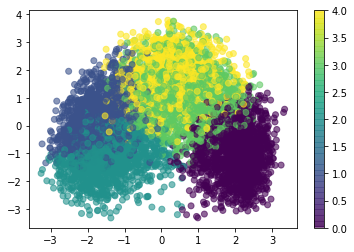

In [120]:
plt.scatter(pca_df['x'],pca_df['y'],c=pca_df['kmeans label'],alpha=.6)
plt.colorbar()
plt.show()

The clusters are quite clear (above)! But they don't correspond very well to voter likelihood (below).

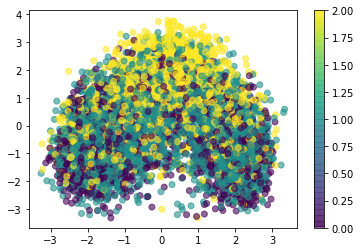

In [121]:
plt.scatter(pca_df['x'],pca_df['y'],c=pca_df['voter code'],alpha=.6)
plt.colorbar()
plt.show()

Perform PCA on dataframe with dummy variables (with drops)

In [ ]:
df_wrangled.head()

In [123]:
X_train.shape

(4668, 219)

In [122]:
pca = PCA(n_components='mle')
pca.fit(X_train)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
print(pca.n_components_)

218


In [124]:
# determine the cumulative explained variance and at what number
# component it occurs
index = []
cumulative = []
perc = 0
for i, p in enumerate(pca.explained_variance_ratio_):
    perc += p
    cumulative.append((i,perc))

In [125]:
cumulative

[(0, 0.07435760193740419),
 (1, 0.12956984247425568),
 (2, 0.16464821706899996),
 (3, 0.18780353443038428),
 (4, 0.20987423928263788),
 (5, 0.22768570215309739),
 (6, 0.2439585197446476),
 (7, 0.25953703516476845),
 (8, 0.27453893015823383),
 (9, 0.28888515670761145),
 (10, 0.3027746767226864),
 (11, 0.31539457928879716),
 (12, 0.32749678532962884),
 (13, 0.33927742611564077),
 (14, 0.35085145372548304),
 (15, 0.3616099966011094),
 (16, 0.3719933300836614),
 (17, 0.38212745485236715),
 (18, 0.3920364017592388),
 (19, 0.40183342100701497),
 (20, 0.41151126355504286),
 (21, 0.42116528114943697),
 (22, 0.43065775138022183),
 (23, 0.43994325229667197),
 (24, 0.44908260543970413),
 (25, 0.45812207172644753),
 (26, 0.4670317395951796),
 (27, 0.47577010401261777),
 (28, 0.48436909101681674),
 (29, 0.4927993103089715),
 (30, 0.5011957458031095),
 (31, 0.5094972855733432),
 (32, 0.5175761828654603),
 (33, 0.5255786859552998),
 (34, 0.5335351264992401),
 (35, 0.541374775354097),
 (36, 0.54915272

~90% explained variance occurs at principal component 106

In [126]:
components = pca.components_
component1 = pca.components_[0]
component2 = pca.components_[1]

In [127]:
component1.shape

(219,)

In [128]:
pca1 = np.dot(X_train,component1)
pca2 = np.dot(X_train,component2)

In [129]:
pca1.shape

(4668,)

In [130]:
pca_2 = pd.DataFrame({'PCA1':pca1,'PCA2':pca2,'y':y_train})


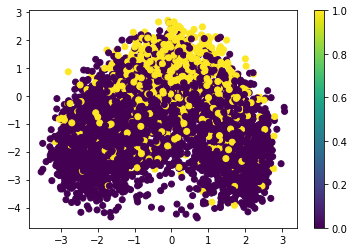

In [132]:
_ = plt.scatter(pca_2['PCA1'], pca_2['PCA2'],c = pca_2['y'])
plt.colorbar() #  1 'Never' & 0 is 'Always' + 'Sporadic'
plt.show()

The best 2 principal components do a decent job of separating nonvoters from others.

In [133]:
print(X_train.shape)
print(components.shape)

(4668, 219)
(218, 219)


In [150]:
pca_train = pd.DataFrame()
for i in range(105):
    pca_train['pca_'+str(i+1)] = np.dot(X_train,components[i])

# apply new PCA to X_test

pca_test = pd.DataFrame()
for i in range(105):
    pca_test['pca_'+str(i+1)] = np.dot(X_test,components[i])

In [139]:
pca_train.shape

(4668, 105)

In [ ]:
x_cols = pca_df.to_numpy()
x_cols

In [ ]:
# Update code to find clusters ~10 columns of PCA matrix
ss_means = []
k_list = []
for k in range(2,8): 
    ss = []
    k_list.append(k)
    for run in range(3):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit_predict(x_cols)
        ss.append(kmeans.inertia_)
    ss_means.append(np.mean(ss))
print(k_list,ss_means)

In [147]:
# Randomized hyperparameter tuning
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(pca_train,y_train)
rf_random.best_params_

{'n_estimators': 290,
 'min_samples_split': 50,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 43,
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [172]:
# Run Random Forests on pca_train with y_train as label

clf = RandomForestClassifier(n_estimators=290,
                             min_samples_split= 50,
                             min_samples_leaf= 2,
                             max_features= 'log2',
                             class_weight= 'balanced_subsample',
                             bootstrap= True,                             
                             max_depth = 5,
                             random_state = 123, 
                             n_jobs=-1)

# train model, 
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(clf, pca_train, pca_test, y_train, y_test)


Random Forest: Test Accuracy=0.842
Random Forest: Test Precision=0.582
Random Forest: Test Recall=0.646
[[837 105]
 [ 80 146]]
Random Forest: Train Accuracy=0.863
Random Forest: Train Precision=0.637
Random Forest: Train Recall=0.748


In [92]:
clf.feature_importances_

array([0.04, 0.15, 0.05, 0.04, 0.06, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04,
       0.03, 0.03, 0.03, 0.03, 0.04, 0.03, 0.03, 0.03, 0.03, 0.05, 0.03,
       0.03, 0.04, 0.03])

The Random Forest model is not improved with PCA matrix.

Now try combining PCA matrix with original X data and run Random Forest.

Add labels to X

In [199]:
print(X_train.shape)
print(pca_train.shape)
print(X_test.shape)
print(pca_test.shape)

(4668, 219)
(4668, 105)
(1168, 219)
(1168, 105)


In [203]:
Xl = pd.concat([X_train,X_test],axis=0)
pca_concat = pd.concat([pca_train,pca_test],axis=0)

In [204]:
pca_concat.head()

pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0 -1.696424 -2.155302 -0.438042  0.760272 -1.940999  0.511014  1.652091   
1  0.855802 -2.658434 -1.383888  0.780619 -0.161552  0.651338  0.614545   
2  1.886441 -0.686249 -2.048540 -0.534643 -1.676540  0.062370  1.853974   
3  0.361119 -0.839742 -1.833630  1.998863 -0.620591  1.423481  0.483070   
4  0.078436 -0.905232 -3.457217  0.945223 -0.322227 -0.115963  1.456143   

      pca_8     pca_9    pca_10  ...    pca_96    pca_97    pca_98    pca_99  \
0 -1.068175  1.380146  0.970077  ...  0.409336 -0.279948 -0.349626  0.097642   
1  0.040112 -0.119106 -0.384887  ...  0.639550  0.400913 -0.334039 -0.506692   
2 -0.272869  0.328781  1.723506  ...  0.186933  0.528480  0.108592 -0.163483   
3 -0.076401 -0.115898 -0.472754  ...  0.357064  0.117770 -0.252473 -0.015268   
4 -0.312021  0.821460  0.805595  ...  0.195827  0.225797  0.059675 -0.133429   

    pca_100   pca_101   pca_102   pca_103   pca_104   pca_105  
0 -0.536204  0.230593  0.454282 -0.728711 -0.169492 -0.159961  
1 -0.136483  0.852212  0.263106  0.062559 -0.146380 -0.298958  
2  0.226673  0.333665  0.094327 -0.305627  0.543993 -0.535281  
3  0.576743 -0.268175 -0.261939 -0.483371  0.028192  0.188381  
4 -0.190837 -0.239958 -0.108603  0.049799 -0.007041 -0.199362  

[5 rows x 105 columns]

In [205]:
for col in pca_concat.columns:
    Xl[col] = pca_concat[col].to_numpy()

In [207]:
Xl['labels']=labels
Xl.shape

(5836, 325)

In [228]:
df_labels_pca = pd.concat([Xl,y],axis=1)

In [231]:
X, y, X_train, X_test, y_train, y_test = split_data(df_labels_pca,test_size=0.2,random_state=42)

KeyError: "['voter_category_sporadic'] not found in axis"

In [ ]:
# Randomized hyperparameter tuning
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 100, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_PCA_train,y_train)
rf_random.best_params_

In [211]:
clf = RandomForestClassifier(n_estimators=300,
                             max_depth = 5,
                             random_state = 123, 
                             n_jobs=-1)

In [212]:
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, rec, cm, train_ac, train_rec, train_prec = RF_model_results(clf, Xl_train, Xl_test, yl_train, yl_test)

Random Forest: Test Accuracy=0.799
Random Forest: Test Precision=0.000
Random Forest: Test Recall=0.000
[[933   0]
 [235   0]]
Random Forest: Train Accuracy=0.799
Random Forest: Train Precision=0.000
Random Forest: Train Recall=0.000


C:\Users\Drew\miniconda3\envs\dsmin\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Drew\miniconda3\envs\dsmin\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Classifier

In [ ]:
lrc = LogisticRegression(random_state=123,n_jobs=-1)
#lrc.fit(X_PCA_train,y_train)

In [ ]:
#lrc.prediction(X_PCA_test,y_test)

In [ ]:
model_res, y_pred, y_pred_prob, lr_probs, ac, prec, 
rec, cm, train_ac, train_rec, train_prec = 
RF_model_results(lrc, X_PCA_train, X_PCA_test, y_train, y_test)